## Requirements

In [1]:
import sympy
from sympy import init_printing, symbols
from sympy import cos, sin, Derivative, pi

init_printing()

## Simple pendulum

We want to describe a pendulum suspended from the origin with a length $l$ and a mass $m$, subject to gravity (gravitational accelleration $g$).  The angle the pendulum makes with the $Y$-axis is $\theta(t)$ where $t$ is the time.
![simple pendulum](img/pendulum.png)

### Equation of motion using Euler-Langrange equation

In [2]:
t, l, g, m = symbols('t l g m', real=True, positive=True)

$\theta$ is a function of $t$, this can be defined explicitely as follows.

In [3]:
theta = symbols(r'\theta', cls=sympy.Function)
theta = theta(t)

The $x$ and $y$ coordinates can be expressed as a function of $theta$:

In [4]:
x = l*sin(theta)
y = -l*cos(theta)
x, y

We can now express the kinetic and potential energy in function of $x$ and $y$.  The kinetic energy is given by:
$$
    T = \frac{1}{2} m (v_x^2 + v_y^2)
$$
and the potential energy by:
$$
    U = m g y
$$
The Langragian is $L = T - U$.

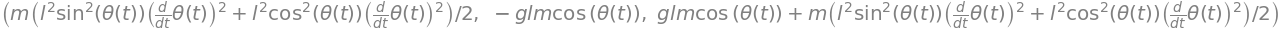

In [5]:
T = m*(x.diff(t)**2 + y.diff(t)**2)/2
U = m*g*y
L = T - U
T, U, L

For convenience, we define $\dot{\theta}(t) = \frac{d \theta}{d t}(t)$ and $\ddot{\theta} = \frac{d \dot{\theta}}{d t}(t)$.

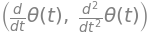

In [6]:
theta_dot = theta.diff(t)
theta_dot_dot = theta_dot.diff(t)
theta_dot, theta_dot_dot

Now we can formulate the Euler-Lagrange equation:
$$
    \frac{\partial L}{\partial \theta} - \frac{d}{d t} \frac{\partial L}{\partial \dot{\theta}} = 0
$$

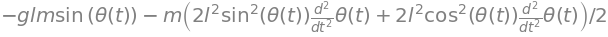

In [7]:
EL_eq = L.diff(theta) - L.diff(theta_dot).diff(t)
EL_eq

Now we can solve for $\ddot{\theta}(t)$, which gives us the differential equation for the motion of the pendulum.

In [8]:
rhs = sympy.solve(EL_eq, theta_dot_dot)[0]
rhs

Now we have the second order ordinary differential equation that we can solve for $\theta(t)$:
$$
    \ddot{\theta}(t) = - \frac{g}{l} \sin \theta(t)
$$

However, this equation is not linear, and no analytic solution is known.  We can either solve it numerically, or approximate the solution for small values of $\theta(t)$ by a Taylor series expansion to first order.

### Approximate analytic solution

In [9]:
x = symbols('x')
lin_rhs = rhs.subs(theta, x) \
    .series(x, 0, n=2).removeO() \
    .subs(x, theta)

Note that we need to fiddle a bit since the `series` method doesn't work when the variable we want to do the series expansion in is a function.  Hence we substitute $x$ for $\theta(t)$, do the series expansion to second order, drop the $O(x^2)$ term and substitute $\theta(t)$ back in for $x$.

Now we can solve the second order ordinary differential equation analytically, and we obtain the well-known solution.

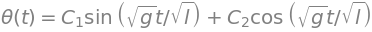

In [10]:
solution = sympy.dsolve(Derivative(theta, t, t) - lin_rhs, theta)
solution

$C_1$ and $C_2$ can be determined by imposing initial conditions on $\theta(0)$ and $\dot{\theta}(0)$.
$$
    \begin{cases}
        \theta(0) = \theta_0 \\
        \dot{\theta}(0) = \omega_0
    \end{cases}
$$


In [11]:
theta_0 = symbols(r'\theta_0', real=True)
omega_0 = symbols(r'\omega_0', real=True)

First we get the symbols for $C_1$ and $C_2$ in the solution using `epath`.

In [12]:
C_1 = sympy.epath('/[0]/[0]', solution.rhs)[0]
C_2 = sympy.epath('/[1]/[0]', solution.rhs)[0]
C_1, C_2

Next, we can solve for $C_2$ using the expression for $\theta(0)$:

In [13]:
C_sols = sympy.solve(solution.rhs.subs(t, 0) - theta_0, C_2, dict=True)[0]
C_sols

Subsequently, we can solve for $C_1$ using the expression for $\dot{\theta}(0)$:

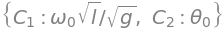

In [14]:
C_sols.update(sympy.solve(solution.rhs.diff(t).subs(t, 0) - omega_0, C_1,
                          dict=True)[0])
C_sols

We obtain the final solution by substituting the values of $C_1$ and $C_2$ into the original solution.

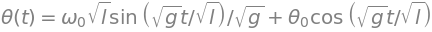

In [15]:
final_solution = solution.subs(C_sols)
final_solution

We can now plot the solution for $l = g = 9.81$, and an initial angle $\theta = 0.1$ and angular velocity $\omega_0 = 0.05$.

In [16]:
values = {
    l: 9.81,
    g: 9.81,
    theta_0: 0.1,
    omega_0: 0.05,
}

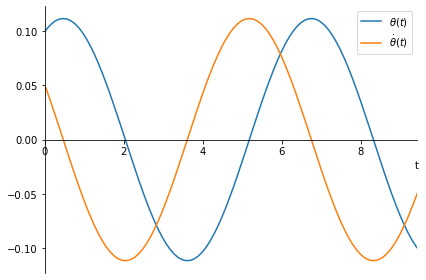

In [17]:
plot = sympy.plot(final_solution.rhs.subs(values),\
                  final_solution.rhs.diff(t).subs(values),
                  xlim=(0.0, 3*pi),
                  ylabel=None,
                  adaptive=False, nb_of_points=200,
                  show=False)
plot[0].label = r'$\theta(t)$'
plot[1].label = r'$\dot{\theta}(t)$'
plot.legend = True
plot.show()

This approximation will produce unrealistic results for large values of $\theta_0$.

In [18]:
values = {
    l: 9.81,
    g: 9.81,
    theta_0: 3.0,
    omega_0: 0.0,
}

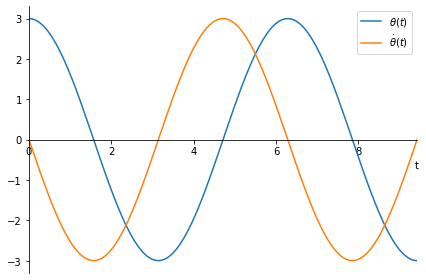

In [19]:
plot = sympy.plot(final_solution.rhs.subs(values),\
                  final_solution.rhs.diff(t).subs(values),
                  xlim=(0.0, 3*pi),
                  ylabel=None,
                  adaptive=False, nb_of_points=200,
                  show=False)
plot[0].label = r'$\theta(t)$'
plot[1].label = r'$\dot{\theta}(t)$'
plot.legend = True
plot.show()

### Numerical solution

We can of course use scipy to solve the equation of motion numerically.  However, scipy's ODE solver can only handle sets of first order equations, and we also can provide the Jacobian in order to speed up the computations.

Rewriting the second order differential equation of the form $\ddot{\theta} = f(\dot{\theta}, \theta, t)$ is straightforward.  We introduce $\omega(t) = \dot{\theta}(t)$ to obtain:
$$
    \begin{cases}
        \frac{d \theta}{d t}(t) = \omega(t) \\
        \frac{d \omega}{d t}(t) = f(\omega(t), \theta(t), t)
    \end{cases}
$$

In [20]:
omega = symbols(r'\omega', cls=sympy.Function)
omega = omega(t)

In [21]:
eqs_rhs = sympy.Matrix([omega, rhs])
eqs_rhs

⎡    \omega(t)     ⎤
⎢                  ⎥
⎢-g⋅sin(\theta(t)) ⎥
⎢──────────────────⎥
⎣        l         ⎦

In [22]:
funcs = sympy.Matrix([theta, omega])
funcs

⎡\theta(t)⎤
⎢         ⎥
⎣\omega(t)⎦

The Jacobian is given by:
$$
    \left(
        \begin{matrix}
            \frac{\partial f_1}{\partial \theta} & \frac{\partial f_1}{\partial \omega} \\
            \frac{\partial f_2}{\partial \theta} & \frac{\partial f_2}{\partial \omega}
        \end{matrix}
    \right)
$$

In [23]:
jacobian = sympy.Matrix(2, 2, lambda i, j: eqs_rhs[i].diff(funcs[j]))
jacobian

⎡        0           1⎤
⎢                     ⎥
⎢-g⋅cos(\theta(t))    ⎥
⎢──────────────────  0⎥
⎣        l            ⎦

To convert the sympy expressions to standard Python function, we can use the `lambdify` function.  However, this will not work for expressions that contain sympy `Function` objects, so we will substitute $x$ for $\theta(t)$ and $y$ for $\omega(t)$.

In [28]:
x, y = symbols('x y')

In [29]:
subs_dict = {
    theta: x,
    omega: y,
}

In [30]:
eqs_rhs.subs(subs_dict)

⎡    y     ⎤
⎢          ⎥
⎢-g⋅sin(x) ⎥
⎢──────────⎥
⎣    l     ⎦

In [31]:
jacobian.subs(subs_dict)

⎡    0       1⎤
⎢             ⎥
⎢-g⋅cos(x)    ⎥
⎢──────────  0⎥
⎣    l        ⎦

In [32]:
rhs_funcs = sympy.lambdify((t, x, y, g, l), eqs_rhs.subs(subs_dict))
jac_funcs = sympy.lambdify((t, x, y, g, l), jacobian.subs(subs_dict))

This functions can be used for scipy.

In [33]:
def sp_funcs(t, Y, g, l):
    theta, omega = Y
    return rhs_funcs(t, theta, omega, g, l)

In [34]:
def sp_jac(t, Y, g, l):
    theta, omega = Y
    return jac_funcs(t, theta, omega, g, l)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import ode

In [36]:
def solve_system(t0, t_max, delta_t, theta0, omega0, g, l):
    system = ode(sp_funcs, sp_jac) \
        .set_integrator('dopri5') \
        .set_f_params(g, l) \
        .set_jac_params(g, l) \
        .set_initial_value((theta0, omega0), t0)

    t_values, theta_values, omega_values = [t0], [theta0], [omega0]
    while system.successful() and system.t <= t_max:
        system.integrate(system.t + delta_t)
        t_values.append(system.t)
        theta_values.append(system.y[0])
        omega_values.append(system.y[1])
        
    return t_values, theta_values, omega_values

In [37]:
def plot_solutions(t_values, theta_values, omega_values):
    plt.plot(t_values, theta_values, label=r'$\theta(t)$')
    plt.plot(t_values, omega_values, label=r'$\dot{\theta}(t)$')
    plt.xlabel(r'$t$')
    plt.legend()
    return

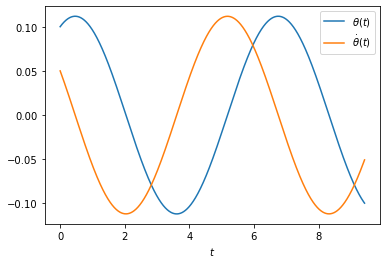

In [38]:
t_vals, theta_vals, omega_vals = solve_system(t0=0.0, delta_t=0.005, t_max=3.0*np.pi,
                                              theta0=0.1, omega0=0.05,
                                              g=9.81, l=9.81)
plot_solutions(t_vals, theta_vals, omega_vals)

For small values of $\theta_0$ and $\omega_0$, there is little difference between the approximate analytic solution and the numeric solution is very small.  However, for large values of $\theta_0$, differences are significant and qualitatively different.

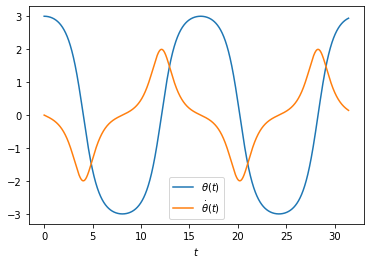

In [39]:
t_vals, theta_vals, omega_vals = solve_system(t0=0.0, delta_t=0.005, t_max=10.0*np.pi,
                                              theta0=3.0, omega0=0.0,
                                              g=9.81, l=9.81)
plot_solutions(t_vals, theta_vals, omega_vals)

## Double pendulum

The double pendulum is more complicated system that can even exhibit chaotic behavior.  We consider two pendulums with length $l_1$ and $l_2$, masses $m_1$ and $m_2$ respectively.  The second pendulum is attached to the end of the first.  Their angles with respect to the $Y$-axis are $\theta_1$ and $\theta_2$ respectively.
![double pendulum](img/double_pendulum.png)

In [40]:
l1, m1 = symbols('l_1 m_1', real=True, positive=True)
l2, m2 = symbols('l_2 m_2', real=True, positive=True)
t, g = symbols('t g', real=True, positive=True)

Define the functions $\theta_1(t)$ and $\theta_2(t)$.

In [41]:
theta1, theta2 = symbols(r'\theta_1 \theta_2', cls=sympy.Function)
theta1, theta2 = theta1(t), theta2(t)

Now we can express the carthesian coordinates of the two masses of the pendulum as functions of $\theta_1(t)$ and $\theta_2(t)$.

In [42]:
x1, y1 = l1*sin(theta1), -l1*cos(theta1)
x2, y2 = x1 + l2*sin(theta2), y1 - l2*cos(theta2)

In [43]:
x1, y1

In [44]:
x2, y2

Next, we can define the kinetic energy $T$ and the potential energy $U$ of the system, as well as the Lagrangian $L = T - U$.

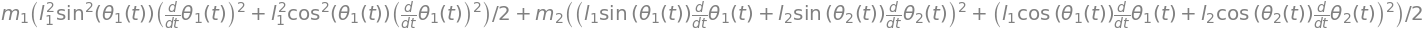

In [45]:
T = m1*(x1.diff(t)**2 + y1.diff(t)**2)/2 + \
    m2*(x2.diff(t)**2 + y2.diff(t)**2)/2
T

In [46]:
U = m1*g*y1 + m2*g*y2
U

In [47]:
L = T - U

As for the simple pendulum, we can solve the set of Euler-Lagrange equations:
$$
    \begin{cases}
        \frac{\partial L}{\partial \theta_1} - \frac{d}{d t} \frac{\partial L}{\partial \dot{\theta_1}} = 0 \\
        \frac{\partial L}{\partial \theta_2} - \frac{d}{d t} \frac{\partial L}{\partial \dot{\theta_2}} = 0
    \end{cases}
$$

For convenience, we define $\dot{\theta}_1(t)$, $\dot{\theta}_2(t)$, $\ddot{\theta}_1(t)$ and $\ddot{\theta}_2(t)$.

In [48]:
theta1_dot, theta2_dot = theta1.diff(t), theta2.diff(t)
theta1_ddot, theta2_ddot = theta1_dot.diff(t), theta2_dot.diff(t)

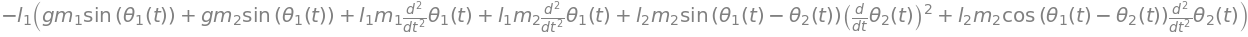

In [49]:
EL_eq1 = (L.diff(theta1) - L.diff(theta1_dot).diff(t)).simplify()
EL_eq1

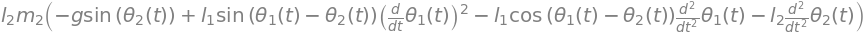

In [50]:
EL_eq2 = (L.diff(theta2) - L.diff(theta2_dot).diff(t)).simplify()
EL_eq2

In [51]:
rhs = sympy.solve({EL_eq1, EL_eq2}, {theta1_ddot, theta2_ddot})

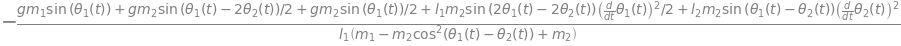

In [52]:
rhs[theta1_ddot].simplify()

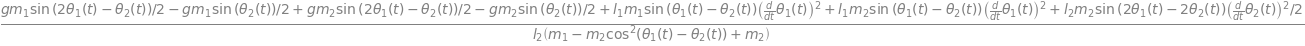

In [53]:
rhs[theta2_ddot].simplify()

Setting $m_2 = 0$ in the solution for $\ddot{\theta}_1$ should yield the result for a simple pendulum.

In [54]:
rhs[theta1_ddot].subs(m2, 0)

To solve this system of ordinary differential equations, we have to convert it to a set of first order equations as we did for the simple pendulum.  Hence we will end up with four equations for $\theta_1$, $\dot{\theta}_1$, $\theta_2$ and $\dot{\theta}_2$.

To convert the sympy expressions to regular Python functions, we need to substitute the functions for simple symbols.  We will use $x_1$, $y_1$, $x_2$, $y_2$ respectively.

In [55]:
funcs = x1, y1, x2, y2 = symbols('x_1 y_1 x_2 y_2')
subst = {
    theta1: x1,
    theta1_dot: y1,
    theta2: x2,
    theta2_dot: y2,
}

The right hand sides of the first order differential equations is given by the following list.

In [56]:
eqs = [
    y1,
    rhs[theta1_ddot].subs(subst),
    y2,
    rhs[theta2_ddot].subs(subst),
]

Next, we can derive the Jacobian which is a $4 \times 4$ matrix in this case.

In [57]:
jacobian = sympy.Matrix(4, 4, lambda i, j: eqs[i].diff(funcs[j]))
jacobian

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                       2                                     
⎢  2⋅g⋅l₂⋅m₁⋅m₂⋅sin(x₁)⋅sin(x₁ - x₂)⋅cos (x₁ - x₂)  

In [58]:
rhs_funcs = sympy.lambdify((t, x1, y1, x2, y2, g, m1, l1, m2, l2),
                           eqs)
jac_funcs = sympy.lambdify((t, x1, y1, x2, y2, g, m1, l1, m2, l2),
                           jacobian)

In [59]:
def sp_funcs(t, Y, g, m1, l1, m2, l2):
    theta1, omega1, theta2, omega2 = Y
    return rhs_funcs(t, theta1, omega1, theta2, omega2,
                     g, m1, l1, m2, l2)

In [60]:
def sp_jac(t, Y, g, m1, l1, m2, l2):
    theta1, omega1, theta2, omega2 = Y
    return jac_funcs(t, theta1, omega1, theta2, omega2,
                     g, m1, l1, m2, l2)

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import ode

We can now compute the solutions and plot the results.

In [62]:
def solve_system(t0, t_max, delta_t,
                 theta1_0, omega1_0, theta2_0, omega2_0,
                 g, m1, l1, m2, l2):
    system = ode(sp_funcs, sp_jac) \
        .set_integrator('dopri5') \
        .set_f_params(g, m1, l1, m2, l2) \
        .set_jac_params(g, m1, l1, m2, l2) \
        .set_initial_value((theta1_0, omega1_0, theta2_0, omega2_0), t0)

    t_vals, theta1_vals, omega1_vals, theta2_vals, omega2_vals = \
        [t0], [theta1_0], [omega1_0], [theta2_0], [omega2_0]
    while system.successful() and system.t <= t_max:
        system.integrate(system.t + delta_t)
        t_vals.append(system.t)
        theta1_vals.append(system.y[0])
        omega1_vals.append(system.y[1])
        theta2_vals.append(system.y[2])
        omega2_vals.append(system.y[3])

        
    return t_vals, theta1_vals, omega1_vals, theta2_vals, omega2_vals

In [63]:
def plot_solutions(t_values, theta1_vals, omega1_vals,
                   theta2_vals, omega2_vals):
    figure, axes = plt.subplots(2, 1)
    axes[0].plot(t_values, theta1_vals, label=r'$\theta_1(t)$')
    axes[0].plot(t_values, omega1_vals, label=r'$\dot{\theta}_1(t)$')
    axes[0].set_xlabel(r'$t$')
    axes[1].plot(t_values, theta2_vals, label=r'$\theta_2(t)$')
    axes[1].plot(t_values, omega2_vals, label=r'$\dot{\theta}_2(t)$')
    axes[1].set_xlabel(r'$t$')
    figure.legend()
    return

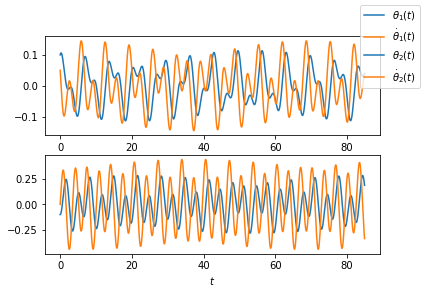

In [64]:
t_vals, theta1_vals, omega1_vals, theta2_vals, omega2_vals = \
    solve_system(t0=0.0, delta_t=0.005, t_max=27.0*np.pi,
                 theta1_0=0.1, omega1_0=0.05,
                 theta2_0=-0.1, omega2_0 = 0.0,
                 g=9.81, m1=1.0, l1=9.81, m2=0.5, l2=9.81/2.0)
plot_solutions(t_vals, theta1_vals, omega1_vals, theta2_vals, omega2_vals)